## Movie Data Set Notebook #1 -- General Preprocessing

In [20]:
# General imports here.
import pandas as pd
import numpy as np
import sklearn as sk
import math
import ast
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [21]:
# Read the csv files and index appropriately.
keywords_df = pd.read_csv('./data/keywords.csv')
credits_df = pd.read_csv('./data/credits.csv')
metadata_df = pd.read_csv('./data/movies_metadata.csv')

In [22]:
# These three files seem to be the ones we want. Indexed on ID, we could probably combine them now.
keywords_df = keywords_df.set_index('id')
credits_df = credits_df.set_index('id')
metadata_df = metadata_df.set_index('id')
None

In [23]:
# Join the useful data frames together
temp = keywords_df.join(credits_df)
movie_df = metadata_df.join(temp)

In [24]:
# Here I'm just doing some of the same stuff "The Story of Film" did on Kaggle.
# This all makes sense, it's pretty standard.
movie_df = movie_df.drop(['imdb_id'], axis=1)
movie_df = movie_df.drop(['original_title'], axis=1)
movie_df = movie_df.drop(['video'], axis=1)
base_poster_url = 'http://image.tmdb.org/t/p/w185'
#movie_df['poster_path'] = "<img src='" + base_poster_url + movie_df['poster_path'] + "' style='height:100px;'>"
movie_df['poster_path'] = base_poster_url + movie_df['poster_path']

In [25]:
# Clean up from https://www.kaggle.com/hadasik/movies-analysis-visualization-newbie
def get_values(data_str):
    if isinstance(data_str, float):
        pass
    else:
        values = []
        data_str = ast.literal_eval(data_str)
        if isinstance(data_str, list):
            for k_v in data_str:
                values.append(k_v['name'])
            return values
        else:
            return None

In [26]:
movie_df[['genres']] = movie_df[['genres']].applymap(get_values)
movie_df[['production_companies', 'production_countries']] = movie_df[['production_companies', 'production_countries']].applymap(get_values)
movie_df[['spoken_languages', 'keywords']] = movie_df[['spoken_languages', 'keywords']].applymap(get_values)
movie_df[['cast', 'crew']] = movie_df[['cast', 'crew']].applymap(get_values)
# This takes a while to run.
# Also, it gets rid of character data and position in the crew. We may want that information.

In [27]:
# Make the Collection feature readable. The previously defined function doesn't seem to work for this feature.
temp = movie_df[movie_df['belongs_to_collection'].notnull()]
temp = temp['belongs_to_collection'].apply(ast.literal_eval).apply(lambda x: x['name'] if isinstance(x, dict) else np.nan)
for index in temp.index:
    movie_df.loc[index, 'belongs_to_collection'] = temp.loc[index]
movie_df['belongs_to_collection'].fillna(0, inplace=True)

In [28]:
# I took care of some of the NaN values already.
movie_df = movie_df[pd.notnull(movie_df['title'])]
movie_df = movie_df[pd.notnull(movie_df['keywords'])]
movie_df = movie_df[pd.notnull(movie_df['original_language'])]
movie_df = movie_df[pd.notnull(movie_df['status'])]
movie_df = movie_df[pd.notnull(movie_df['release_date'])]
movie_df = movie_df[pd.notnull(movie_df['poster_path'])]
movie_df = movie_df[pd.notnull(movie_df['overview'])]
movie_df = movie_df[pd.notnull(movie_df['runtime'])]

In [29]:
# Make the homepage feature a binary variable since we don't care what the URL is.
movie_df['homepage'].fillna(0, inplace=True)
movie_df.loc[movie_df['homepage'] != 0, 'homepage'] = 1
movie_df['homepage'] = movie_df['homepage'].astype(np.int64)

In [30]:
# Replace tagline NaNs
movie_df['tagline'].fillna(0, inplace=True)
# Drop status when not released.
movie_df = movie_df.loc[movie_df['status'] == 'Released']
movie_df = movie_df.drop(['status'], axis = 1)

In [32]:
# Take care of budget, revenue
print(movie_df.shape)
movie_df = movie_df.loc[movie_df['revenue'] != 0]
movie_df = movie_df.loc[movie_df['budget'] != 0]
print(movie_df.shape)
movie_df['revenue'] = movie_df['revenue'].apply(lambda x: x if x > 100 else x*1000000)
movie_df['revenue'] = movie_df['revenue'].apply(lambda x: x if (x > 999) else x*1000)
movie_df['budget'] = movie_df['budget'].apply(lambda x: x if x > 100 else x*1000000)
movie_df['budget'] = movie_df['budget'].apply(lambda x: x if (x > 999) else x*1000)

(7502, 20)
(5443, 20)


In [33]:
# Check for NaNs. None, that's good.
print(movie_df.isnull().any())

belongs_to_collection    False
budget                   False
genres                   False
homepage                 False
original_language        False
overview                 False
poster_path              False
production_companies     False
production_countries     False
release_date             False
revenue                  False
runtime                  False
spoken_languages         False
tagline                  False
title                    False
vote_average             False
vote_count               False
keywords                 False
cast                     False
crew                     False
dtype: bool


In [34]:
# belongs_to_collection: Similar to tagline, we may just want a binary variable
# tagline: Until we actually analyze the taglines, I think we should just replace with a tag_presence binary variable
# revenue and budget are both missing a lot of data, we'll have to deal with that.
movie_df.head().transpose()

id,5,11,12,13,14
belongs_to_collection,0,Star Wars Collection,Finding Nemo Collection,0,0
budget,4000000,11000000,94000000,55000000,15000000
genres,"[Crime, Comedy]","[Adventure, Action, Science Fiction]","[Animation, Family]","[Comedy, Drama, Romance]",[Drama]
homepage,0,1,1,0,1
original_language,en,en,en,en,en
overview,It's Ted the Bellhop's first night on the job....,Princess Leia is captured and held hostage by ...,"Nemo, an adventurous young clownfish, is unexp...",A man with a low IQ has accomplished great thi...,"Lester Burnham, a depressed suburban father in..."
poster_path,http://image.tmdb.org/t/p/w185/eQs5hh9rxrk1m4x...,http://image.tmdb.org/t/p/w185/btTdmkgIvOi0FFi...,http://image.tmdb.org/t/p/w185/syPWyeeqzTQIxjI...,http://image.tmdb.org/t/p/w185/yE5d3BUhE8hCnkM...,http://image.tmdb.org/t/p/w185/or1MP8BZIAjqWYx...
production_companies,"[Miramax Films, A Band Apart]","[Lucasfilm, Twentieth Century Fox Film Corpora...",[Pixar Animation Studios],[Paramount Pictures],"[DreamWorks SKG, Jinks/Cohen Company]"
production_countries,[United States of America],[United States of America],[United States of America],[United States of America],[United States of America]
release_date,12/9/1995,5/25/1977,5/30/2003,7/6/1994,9/15/1999


In [35]:
movie_df.describe()

,budget,homepage,revenue,runtime,vote_average,vote_count
count,5.443000e+03,5443.000000,5.443000e+03,5443.000000,5443.000000,5443.000000
mean,3.114843e+07,0.356237,9.026193e+07,109.981995,6.274904,729.087084
std,4.004329e+07,0.478931,1.658673e+08,21.594643,0.921708,1247.718513
min,2.500000e+03,0.000000,1.378000e+03,0.000000,0.000000,0.000000
25%,5.500000e+06,0.000000,7.315342e+06,95.000000,5.700000,77.000000
50%,1.700000e+07,0.000000,3.003939e+07,106.000000,6.300000,275.000000
75%,4.000000e+07,1.000000,9.898360e+07,120.000000,6.900000,794.500000
max,3.800000e+08,1.000000,2.787965e+09,338.000000,9.100000,14075.000000


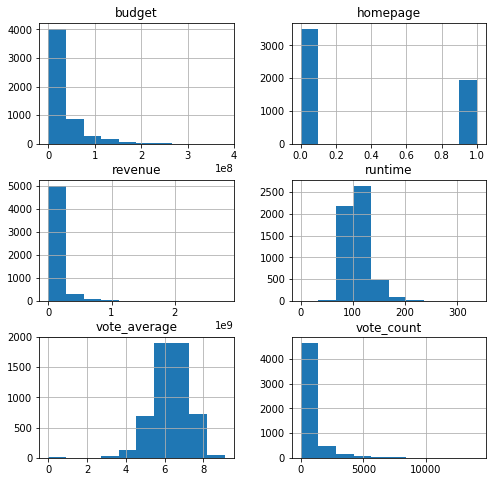

In [36]:
_ = movie_df.hist(figsize=(8,8))

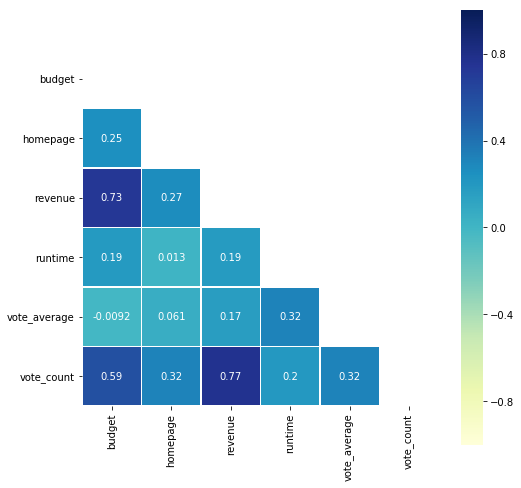

In [37]:
# A quick heatmap. It seems revenue and the number of votes are correlated.
corr = movie_df.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(8, 8))
_ = sns.heatmap(corr, vmax=1, vmin=-1, mask=mask, square=True, annot=True, linewidths=0.2, center=0, cmap="YlGnBu")

In [38]:
# Toy Story Entry Example, looking it up by ID number
print(movie_df.loc[862])

belongs_to_collection                                 Toy Story Collection
budget                                                            30000000
genres                                         [Animation, Comedy, Family]
homepage                                                                 1
original_language                                                       en
overview                 Led by Woody, Andy's toys live happily in his ...
poster_path              http://image.tmdb.org/t/p/w185/rhIRbceoE9lR4ve...
production_companies                             [Pixar Animation Studios]
production_countries                            [United States of America]
release_date                                                    10/30/1995
revenue                                                        3.73554e+08
runtime                                                                 81
spoken_languages                                                 [English]
tagline                  

In [39]:
# You can't use the partially displayed link above.
print(movie_df.loc[862, 'poster_path'])

http://image.tmdb.org/t/p/w185/rhIRbceoE9lR4veEXuwCC2wARtG.jpg


### Actors

In [ ]:
#actors_df = pd.read_csv('./data/actors.csv')
#actors_df = actors_df.set_index('actors')

# way to parse through all the movie lists of actors and crew to find average revenue for each
"""crew_mem = []
num_movies = []
revenue_avg = []
counter = 0
for index, row in movie_df.iterrows():
    crew = row['crew']
    revenue = row['revenue']
    if(counter%1000 == 0):
        print(counter)
    counter += 1
    for person in crew:
        try:
            index = crew_mem.index(person)
        except:
            index = -1
        if(index != -1):
            temp = revenue_avg[index] * num_movies[index]
            temp += revenue
            num_movies[index] += 1
            revenue_avg[index] = temp/num_movies[index]
        else:
            crew_mem.append(person)
            num_movies.append(1)
            revenue_avg.append(revenue)"""
None

In [ ]:
#actors_df = pd.read_csv('./data/actors.csv')
#actors_df = actors_df.set_index('actors')
x = []
for i in range(0,actors_df.shape[0]):
    x.append(i)
rev = actors_df['average_revenue']
mov = actors_df['number_of_movies']
rev_sh = actors_df['average_revenue (shifted)']
plt.plot(x,rev, 'ro')
plt.title("Average Revenue for each Actor")
plt.show()

In [ ]:
plt.plot(x,mov, 'ro')
plt.title("Number of Movies per Actor")
plt.show()

In [ ]:
plt.plot(x,rev_sh, 'ro')
plt.title("(Avg Revenue for each Actor) * Number of Movies")
plt.show()

In [ ]:
actor = actors_df['average_revenue'].argmax()
actor2 = actors_df['number_of_movies'].argmax()
actor3 = actors_df['average_revenue (shifted)'].argmax()
print ("Largest Average Revenue:")
print("Actor: " + actor + "  Num_Movies: " + str(actors_df.loc[actor,'number_of_movies']) + "  Avg_Revenue: " + str(actors_df.loc[actor,'average_revenue']) + "\n")
print ("Most Movies:")
print("Actor: " + actor2 + "  Num_Movies: " + str(actors_df.loc[actor2,'number_of_movies']) + "  Avg_Revenue: " + str(actors_df.loc[actor2,'average_revenue']) + "\n")
print ("Largest Average Shifted Revenue:")
print("Actor: " + actor3 + "  Num_Movies: " + str(actors_df.loc[actor3,'number_of_movies']) + "  Avg_Revenue: " + str(actors_df.loc[actor3,'average_revenue']) + "\n")

In [51]:
def to_file(filename, crew, num_mov, avg_rev):
    with open(filename, 'w') as f:
        f.write('crew,number_of_movies,average_revenue\n')
        for cre, mov, rev in zip(crew, num_mov, avg_rev):
            f.write('{},{},{}\n'.format(cre, mov, rev))

# Haven't tested this yet.
def makeCSV(df, filename):
    df.to_csv(('./data/' + filename), index = True, sep='\t', encoding='utf-8')

### Posters

In [40]:
from PIL import Image

# Taken from https://zeevgilovitz.com/detecting-dominant-colours-in-python
def compare(title, image, color_tuple):
    #image.show(title=title)
    image = Image.new("RGB", (200, 200,), color_tuple)
    return image

def most_frequent_color(image):

    w, h = image.size
    pixels = image.getcolors(w * h)

    most_frequent_pixel = pixels[0]

    for count, color in pixels:
        if count > most_frequent_pixel[0]:
            most_frequent_pixel = (count, color)

    #imshow(compare("Most Common", image, most_frequent_pixel[1]))

    return most_frequent_pixel

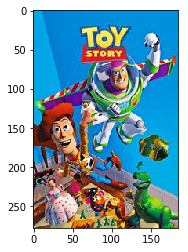

In [41]:
import requests
from io import BytesIO
from matplotlib.pyplot import imshow

# Get Toy Story Poster Image
response = requests.get(movie_df.loc[862]['poster_path'])
img = Image.open(BytesIO(response.content))
imshow(img)

In [42]:
import random
import numpy

class Cluster(object):

    def __init__(self):
        self.pixels = []
        self.centroid = None

    def addPoint(self, pixel):
        self.pixels.append(pixel)

    def setNewCentroid(self):

        R = [colour[0] for colour in self.pixels]
        G = [colour[1] for colour in self.pixels]
        B = [colour[2] for colour in self.pixels]

        R = sum(R) / len(R)
        G = sum(G) / len(G)
        B = sum(B) / len(B)

        self.centroid = (R, G, B)
        self.pixels = []

        return self.centroid

class Kmeans(object):
    def __init__(self, k=3, max_iterations=5, min_distance=5.0, size=200):
        self.k = k
        self.max_iterations = max_iterations
        self.min_distance = min_distance
        self.size = (size, size)

    def run(self, image):
        self.image = image
        self.image.thumbnail(self.size)
        self.pixels = numpy.array(image.getdata(), dtype=numpy.uint8)

        self.clusters = [None for i in range(self.k)]
        self.oldClusters = None

        randomPixels = random.sample(self.pixels, self.k)

        for idx in range(self.k):
            self.clusters[idx] = Cluster()
            self.clusters[idx].centroid = randomPixels[idx]

        iterations = 0

        while self.shouldExit(iterations) is False:

            self.oldClusters = [cluster.centroid for cluster in self.clusters]

            print(iterations)

            for pixel in self.pixels:
                self.assignClusters(pixel)

            for cluster in self.clusters:
                cluster.setNewCentroid()

            iterations += 1

        return [cluster.centroid for cluster in self.clusters]

    def assignClusters(self, pixel):
        shortest = float('Inf')
        for cluster in self.clusters:
            distance = self.calcDistance(cluster.centroid, pixel)
            if distance < shortest:
                shortest = distance
                nearest = cluster

        nearest.addPoint(pixel)

    def calcDistance(self, a, b):

        result = numpy.sqrt(sum((a - b) ** 2))
        return result

    def shouldExit(self, iterations):

        if self.oldClusters is None:
            return False

        for idx in range(self.k):
            dist = self.calcDistance(
                numpy.array(self.clusters[idx].centroid),
                numpy.array(self.oldClusters[idx])
            )
            if dist < self.min_distance:
                return True

        if iterations <= self.max_iterations:
            return False

        return True

    # ############################################
    # The remaining methods are used for debugging
    def showImage(self):
        self.image.show()

    def showCentroidColours(self):

        for cluster in self.clusters:
            image = Image.new("RGB", (200, 200), cluster.centroid)
            #image.show()
            plt.imshow(image)
            plt.show()

    def showClustering(self):

        localPixels = [None] * len(self.image.getdata())

        for idx, pixel in enumerate(self.pixels):
                shortest = float('Inf')
                for cluster in self.clusters:
                    distance = self.calcDistance(
                        cluster.centroid,
                        pixel
                    )
                    if distance < shortest:
                        shortest = distance
                        nearest = cluster

                localPixels[idx] = nearest.centroid

        w, h = self.image.size
        localPixels = numpy.asarray(localPixels)\
            .astype('uint8')\
            .reshape((h, w, 3))

        colourMap = Image.fromarray(localPixels)
        #colourMap.show()
        imshow(colourMap)

In [48]:
def get_most_freq_c(url):
    response = requests.get(url)
    image = Image.open(BytesIO(response.content))
    return most_frequent_color(image)

In [49]:
movie_df['most_freq_color'] = movie_df['poster_path'].apply(get_most_freq_c)

(752, (1, 144, 222))


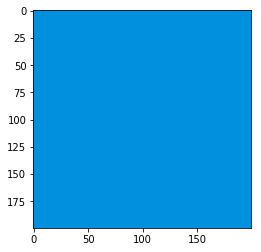

In [50]:
print(movie_df.loc[862]['most_freq_color'])
image = Image.new("RGB", (200, 200,), movie_df.loc[862]['most_freq_color'][1])
imshow(image)

In [47]:
print(movie_df.loc[862])

belongs_to_collection                                 Toy Story Collection
budget                                                            30000000
genres                                         [Animation, Comedy, Family]
homepage                                                                 1
original_language                                                       en
overview                 Led by Woody, Andy's toys live happily in his ...
poster_path              http://image.tmdb.org/t/p/w185/rhIRbceoE9lR4ve...
production_companies                             [Pixar Animation Studios]
production_countries                            [United States of America]
release_date                                                    10/30/1995
revenue                                                        3.73554e+08
runtime                                                                 81
spoken_languages                                                 [English]
tagline                  

In [53]:
makeCSV(movie_df, 'frequent.csv')